In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


In [22]:
# ჩავტვირთოთ დატა დატაფრეიმებში
# 10 მილიონი საკმაოდ ბევრია ამ მოდელებისთვის ამიტომ ნაკლებს ვიყენებ.
# არსებითი მნიშვნელობა არ აქვს 10ს გამოვიყენებ თუ 1-ს, 10 უბრალოდ დიდ ხანს ანდომებს ნეირონული ქსელის დასატრენინგებლად.
# ასევე გადავამოწმე და loss იგივეა გინდ 1 ან 10 მილიონი მონაცემი იყოს
train_df =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows = 1_000_000)
test_df =  pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/test.csv')

In [23]:
# შევხედოთ როგორ გამიყურება, რა სვეტები აქვს
print(train_df)
print(test_df)

# ვნახოთ თუ რამე სტრიქონებს აკლიათ დატა
missing_values = train_df.isnull()
ans = missing_values.sum()
print(ans)

                                  key  fare_amount          pickup_datetime  \
0         2009-06-15 17:26:21.0000001          4.5  2009-06-15 17:26:21 UTC   
1         2010-01-05 16:52:16.0000002         16.9  2010-01-05 16:52:16 UTC   
2        2011-08-18 00:35:00.00000049          5.7  2011-08-18 00:35:00 UTC   
3         2012-04-21 04:30:42.0000001          7.7  2012-04-21 04:30:42 UTC   
4       2010-03-09 07:51:00.000000135          5.3  2010-03-09 07:51:00 UTC   
...                               ...          ...                      ...   
999995    2014-09-13 21:44:38.0000001          7.0  2014-09-13 21:44:38 UTC   
999996    2010-09-20 14:50:37.0000002          7.3  2010-09-20 14:50:37 UTC   
999997  2013-04-26 14:03:00.000000118         10.5  2013-04-26 14:03:00 UTC   
999998   2011-07-08 00:29:00.00000099          6.9  2011-07-08 00:29:00 UTC   
999999   2009-12-31 14:30:00.00000021          4.1  2009-12-31 14:30:00 UTC   

        pickup_longitude  pickup_latitude  dropoff_

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [25]:
# თავიდან შევხედოთ null value-ებს
print(train_df.isnull().sum())

# წავშალოთ null value-ებიანი სტრიქონები
train_df.dropna(inplace=True)

# წავშალოთ უაზრო მონაცემები
train_df = train_df[train_df['passenger_count'] < 8]
# წავშალოთ ისეთი სტრიქონები სადაც გადასახადი უარყოფითია
train_df = train_df[train_df['fare_amount'] > 0]

# Check for missing values
print(train_df.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    10
dropoff_latitude     10
passenger_count       0
dtype: int64
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [26]:
# დავბეჭდოთ მინიმუმი და მაქსიმუმი პოზიციები ტესტ დატაში
min(test_df.pickup_longitude.min(), test_df.dropoff_longitude.min()), \
max(test_df.pickup_longitude.max(), test_df.dropoff_longitude.max())

(-74.263242, -72.986532)

In [27]:
# იგივე ოღონდ latitude-ზე
min(test_df.pickup_latitude.min(), test_df.dropoff_latitude.min()), \
max(test_df.pickup_latitude.max(), test_df.dropoff_latitude.max())

(40.568973, 41.709555)

In [28]:
# აქ ვიყენებ RANGE-ში წინა რიცხვებს რომ  გავფილტრო outlier-ები
RANGE = (-74.26, -72.99, 40.56, 41.71)

# this function will also be used with the test set below
def select_within_boundingbox(df, RANGE):
    return (df.pickup_longitude >= RANGE[0]) & (df.pickup_longitude <= RANGE[1]) & \
           (df.pickup_latitude >= RANGE[2]) & (df.pickup_latitude <= RANGE[3]) & \
           (df.dropoff_longitude >= RANGE[0]) & (df.dropoff_longitude <= RANGE[1]) & \
           (df.dropoff_latitude >= RANGE[2]) & (df.dropoff_latitude <= RANGE[3])

# შევამოწმოთ რამდენი გაიფილტრა
print('Old size: %d' % len(train_df))
train_df = train_df[select_within_boundingbox(train_df, RANGE)]
print('New size: %d' % len(train_df))

Old size: 999922
New size: 978816


In [29]:
from geopy.distance import great_circle

def calculate_distance(df):
    pickup_coords = list(zip(df['pickup_latitude'], df['pickup_longitude']))
    dropoff_coords = list(zip(df['dropoff_latitude'], df['dropoff_longitude']))
    distances = [great_circle(pickup, dropoff).miles for pickup, dropoff in zip(pickup_coords, dropoff_coords)]
    return distances

def add_distance_to_df(df):
    # Calculate distance and add it as a new feature
    df['distance'] = calculate_distance(df)

    # Extract datetime features
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['hour'] = df['pickup_datetime'].dt.hour
    df['day'] = df['pickup_datetime'].dt.day
    df['month'] = df['pickup_datetime'].dt.month
    df['year'] = df['pickup_datetime'].dt.year

# აქ ვაკეთებთ feature-engineering-ს და ვამატებთ დისტანციას.
# კიდე თუ მომაფიქრდა რა დავამატო feature-ად ალბათ ვიზამ
# Note: ამ ნაწილს ცოტა დიდიხანი სჭირდება რო გამოთვალოს
add_distance_to_df(train_df)
add_distance_to_df(test_df)

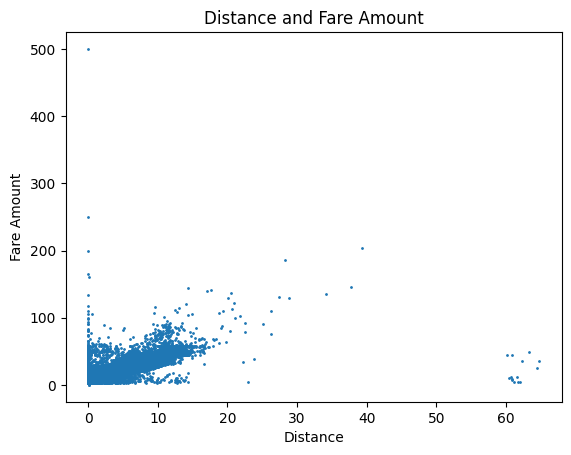

In [30]:
# დავხატოთ და შევამოწმოთ რა ხდება დისტანციასა და გადასახადს შორის
import matplotlib.pyplot as plt

def plt_distance_to_fare(df, sample_size=100_000):
    df = df.sample(sample_size)
    plt.scatter(df['distance'], df['fare_amount'], s=1)
    plt.title('Distance and Fare Amount')
    plt.xlabel('Distance')
    plt.ylabel('Fare Amount')
    plt.show()

plt_distance_to_fare(train_df)

აქ ჩანს რომ ძირითადად წრფივი დამოკიდებულებაა დისტანციასა და ფასს შორის. მარჯვნივ კუთხეში პატარა კუნძულია დატაპოინტების, რაც ვფიქრობ რომ დიდი ალბათობით იქნება აეროპორტიდან წასვლა რადგან ხშირად იგივე ფასს ახდევინებენ ხოლმე. ჩვენი მოდელებისთვის ვფიქრობ რომ ეს კუთხეში არსებული დატაპოინტები გადავყარო. ასევე distance=0 წრფეზეც არის არსებული დატაპოინტები და ვფიქრობ ესენიც გადავაგდო.

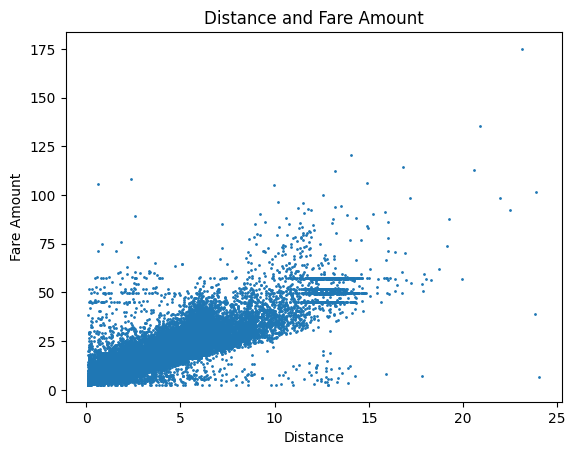

In [31]:
# nn მოდელისთვის არ გამოვიყენებთ ამ outlier გადაგდებულ დატას, რადგან ვფიქრობ რომ უკეთესი პერფორმანსი ექნება თუ მივცემთ outlier-ებს
nn_df = train_df.copy()

train_df = train_df[train_df['distance'] < 25]
train_df = train_df[train_df['distance'] > 0.1]

plt_distance_to_fare(train_df)

ახლა უფრო წრფივად გამოიყურება ეს მონაცემები.

ასევე აქვე მინდა აღვნიშნო, რომ სანამ ამ კონკრეტული outlier-ების წაშლას გავაკეთებდი, მოდელები nn და xgboost მოდელები დაახლოებით 4.2 rmse-ს მაძლევდნენ. წრფივი რეგრესია ორივე შემთხვევაში >5 მაძლევს. თუმცა ამ outlier-ების ამოშლამ გააუარესა nn-ის პერფორმანსი და submission-ში 5.4 rmse მომცა. სამაგიეროდ xgboost ძალიან პერფორმატული გახდა და 3.6-ზე დავიდა.

კი შეიძლებოდა რომ outlier-ები არ წამეშალა და უფრო კომპლექსური მოდელები ამეწყო რომლებიც დამატებით feature-ებს გამოიყენებდნენ, მაგალითად აეროპორტიდან წაყვანა თუ არის და ა.შ. თუმცა გადავწყვიტე რაც უფრო მარტივი იქნება მოდელი მით უკეტესი.


In [32]:
# ავირჩიოთ feature-ები რის მიხედვითაც დავატრენინგებთ
# ამ კომენტარში არის ყველა feature ჩამოთვლილი და მარტო იმათ ვირჩევ რაც ვფიქრობ რომ კარგი იქნება
# features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 
#             'passenger_count', 'distance', 'hour', 'day', 'month', 'year']

## აქ pickup და dropoff არ მქონდა, თუმცა უარეს პერფორმანსს დებდა ამიტომ ჩავამატე. ამ feature-ებით მივიღე 3.6 rmse XGBoost მოდელზე, 
## და შედარებით კარგი მაინც nn მოდელზე (4.2)
features = ['passenger_count', 'distance', 'hour', 'day', 'month', 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
X = train_df[features]
y = train_df['fare_amount']

In [33]:
# ტრენინგი და ვალიდაციის სეტები
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# წრფივი რეგრესიის დატრენინგება
model = LinearRegression()
model.fit(X_train, y_train)

# ვალიდაციის სეტზე წინასწარმეტყველება
y_pred = model.predict(X_valid)

# rmse გამოთვლა
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("RMSE:", rmse)

RMSE: 4.056471257726952


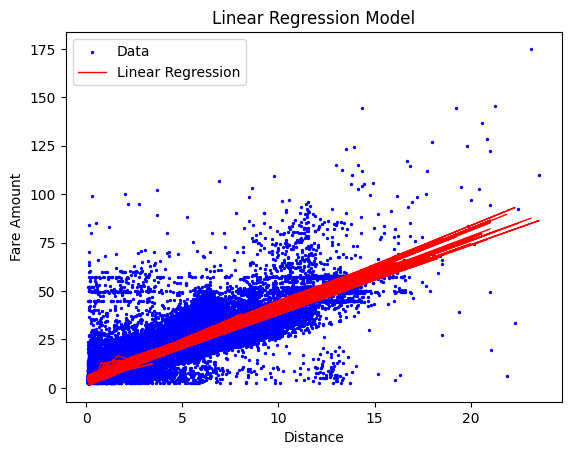

In [34]:
def plot_linear(X_valid, y_valid, y_pred, column='distance'):
    plt.scatter(X_valid[column], y_valid, color='blue', label='Data', s=2)

    plt.plot(X_valid[column], y_pred, color='red', linewidth=1, label='Linear Regression')

    plt.title('Linear Regression Model')
    plt.xlabel('Distance')
    plt.ylabel('Fare Amount')
    plt.legend()
    plt.show()
    
plot_linear(X_valid, y_valid, y_pred)

იდეაში ზუსტად ასეთი გვინდოდა რო ყოფილიყო გრაფი

In [35]:
# ტესტ დატაზე გავუშვათ და შევინახოთ predicted fare-ები submissionის ფორმატში
X = test_df[features]

y_pred = model.predict(X)

print(y_pred)
submission_df = test_df[["key"]]
submission_df["fare_amount"] = y_pred
print(submission_df)

submission_df.to_csv('linear_submission.csv', index=False)

[ 8.91990702  8.80470159  5.03788484 ... 48.01733071 21.4342189
  6.11484938]
                              key  fare_amount
0     2015-01-27 13:08:24.0000002     8.919907
1     2015-01-27 13:08:24.0000003     8.804702
2     2011-10-08 11:53:44.0000002     5.037885
3     2012-12-01 21:12:12.0000002     8.447980
4     2012-12-01 21:12:12.0000003    16.803646
...                           ...          ...
9909  2015-05-10 12:37:51.0000002     8.461334
9910  2015-01-12 17:05:51.0000001    11.456214
9911  2015-04-19 20:44:15.0000001    48.017331
9912  2015-01-31 01:05:19.0000005    21.434219
9913  2015-01-18 14:06:23.0000006     6.114849

[9914 rows x 2 columns]


/tmp/ipykernel_33/3905586705.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission_df["fare_amount"] = y_pred


In [36]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

X = train_df[features]
y = train_df['fare_amount']

# ტრენინგის და ვალიდაციის სეტები
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# xgboost მოდელის დატრენინგება
model = XGBRegressor(learning_rate=0.1)  # You can specify parameters here if needed
model.fit(X_train, y_train)

# წინასწარმეტყველება xgboost-ით
y_pred = model.predict(X_valid)

# rmse-ს დათვლა
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print("RMSE:", rmse)

RMSE: 3.488617153693462


In [37]:
# ტესტ სეტზე წინასწარმეტყველება და შევინახოთ submission-ად
X = test_df[features]

y_pred = model.predict(X)

print(y_pred)
test_df["fare_amount"] = y_pred
submission_df = test_df[["key", "fare_amount"]]
print(submission_df)
submission_df.to_csv('xgboost_submission.csv', index=False)

[ 8.985175  9.408219  5.332005 ... 53.0178   18.699072  6.94189 ]
                              key  fare_amount
0     2015-01-27 13:08:24.0000002     8.985175
1     2015-01-27 13:08:24.0000003     9.408219
2     2011-10-08 11:53:44.0000002     5.332005
3     2012-12-01 21:12:12.0000002     8.338309
4     2012-12-01 21:12:12.0000003    14.557281
...                           ...          ...
9909  2015-05-10 12:37:51.0000002     8.738000
9910  2015-01-12 17:05:51.0000001    10.793058
9911  2015-04-19 20:44:15.0000001    53.017799
9912  2015-01-31 01:05:19.0000005    18.699072
9913  2015-01-18 14:06:23.0000006     6.941890

[9914 rows x 2 columns]


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras import backend as K

# ზოგადი არქიტექტურის ნეირონული ქსელი ორი hidden layer-ით
# პარამეტრების tuning-ის შემდეგ გადავწყვიტე რო ასეთი რაოდენობის პერცეპტრონებით იყოს თითო ლეიერი რადგან დიდად არსებითი მნიშვნელობა არ აქვს
# იმ დატაზე რაზეც ვატრენინგებთ.
model = Sequential([
    Dense(32, activation='relu', input_shape=(len(features),)),
    Dense(16, activation='relu'),
    Dense(1)
])
    
# ვერ დავუყენე rmse loss :(
# ვიყენებ ადამის ოპტიმიზაციას learning_rate-ისთვის
model.compile(optimizer='adam', loss="mean_squared_error")


X = nn_df[features]
y = nn_df['fare_amount']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# დავატრენინგოთ
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=2, batch_size=32) # ბევრი ეპოქა არც სჭირდება, 1-ის მერეც უკვე მაქსიმუმ პერფორმანსს აღწევს

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
24471/24471 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - loss: 29.3149 - val_loss: 24.9903
Epoch 2/2
24471/24471 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - loss: 25.8638 - val_loss: 22.8664


In [39]:
# ევალუაცია
loss = model.evaluate(X_valid, y_valid)
print("Test Loss:", loss)

# ტესტ დატაზე წინასწარმეტყველებები
X = test_df[features]
y_pred = model.predict(X)

6118/6118 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 22.7755
Test Loss: 22.866374969482422
310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [40]:
test_df["fare_amount"] = y_pred
submission_df = test_df[["key", "fare_amount"]]
print(submission_df)
submission_df.to_csv('nn_submission.csv', index=False)

                              key  fare_amount
0     2015-01-27 13:08:24.0000002     9.656781
1     2015-01-27 13:08:24.0000003     9.890571
2     2011-10-08 11:53:44.0000002     6.567008
3     2012-12-01 21:12:12.0000002     8.124671
4     2012-12-01 21:12:12.0000003    15.898275
...                           ...          ...
9909  2015-05-10 12:37:51.0000002     9.325364
9910  2015-01-12 17:05:51.0000001    11.362331
9911  2015-04-19 20:44:15.0000001    48.383873
9912  2015-01-31 01:05:19.0000005    19.790876
9913  2015-01-18 14:06:23.0000006     6.987422

[9914 rows x 2 columns]
